For this solution, I created a database with three tables: documents, tags and tags_documents. <tags> and <documents> have IDs which are primary keys.
In <tags_documents> table, there are tag_id and document_id columns which are connected to IDs in <tags> and <documents> tables correspondingly. Also I added unique key on name of tags in <tags> table since search is based on that.It will allow for fast retrieval of data
    
    


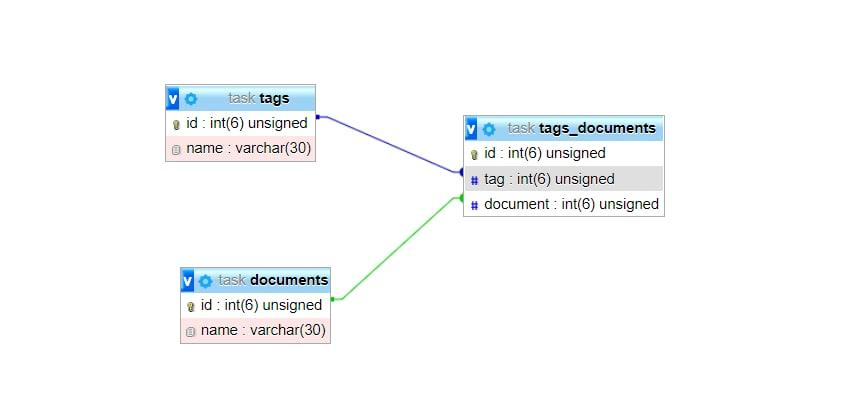

In [13]:
import mysql.connector
from mysql.connector import Error
import sys
import random
from datetime import datetime

In [14]:
# singelton class for database connection
class DBConnector:

    __instance = None

    def __new__(self):
        if not self.__instance:
            self.__instance = super(DBConnector, self).__new__(self)
        return self.__instance

     
    def __init__(self):
        try:
            self.__connection = mysql.connector.connect(host="localhost",
                                                        database="task2",
                                                        user="root",
                                                        password="")
            if self.__connection.is_connected():
                print("Connection established")
                self.__connection_cursor = self.__connection.cursor()      
            else:
                print("ERROR: Cannot connect to database:")
                print(f"    Host: {self.__host}")
                print(f"    Database: {self.__database}")
                print(f"    User: {self.__user}")
                sys.exit()
          
        except Error as e:
            print("Error while connecting to MySQL", e)
            sys.exit()
                          
    def __del__(self):
        if self.__connection: 
            self.close_connection()
            print("Connection closed")
    
    def close_connection(self):
        if self.__connection.is_connected():
            self.__connection.close()
        
    # inserts a row in a table and returns the row's id
    def insert_into_table(self, table, value):
        value = (value,)
        sql = "INSERT INTO {table_name} (name) VALUES  (%s)".format(table_name=table)
        self.__connection_cursor.execute(sql, value)
        self.__connection.commit()
        row_id = self.__connection_cursor.lastrowid
        return row_id

    # check if the tag/document is present in db
    # if not, insert it
    # return the id of the value
    def insert_and_get_id(self, table, value):
        sql = "SELECT id from {table_name} WHERE name='{value}'".format(table_name=table, value=value)
        self.__connection_cursor.execute(sql)
        row_id = self.__connection_cursor.fetchone()
        if row_id is None:
            row_id = self.insert_into_table(table, value)
        else:
            row_id = row_id[0]
                          
        return row_id
    
    # create a relationship between the document and tag by inserting their ids in <tags_documents> table
    def create_relationship(self, doc_tag_id):
        # temporarily disabe checks on foreghn key in order to insert into the table 
        sql = "SET FOREIGN_KEY_CHECKS=OFF;"
        self.__connection_cursor.execute(sql)
        self.__connection.commit()
        self.__connection_cursor.reset()
        # insert              
        sql = "INSERT INTO tags_documents (document, tag) VALUES (%s, %s)"
        self.__connection_cursor.execute(sql, doc_tag_id)
        self.__connection.commit()
        self.__connection_cursor.reset()
        # turn checks back on                  
        sql = "SET FOREIGN_KEY_CHECKS=ON;"
        self.__connection_cursor.execute(sql)
        self.__connection.commit()
        self.__connection_cursor.reset()
    
    # given the document and the set of tags it is associated with, insert them in <documents> and <tags> tables
    # do not create relationship yet
    def insert_tagged_doc(self, document, tags):
        doc_id = self.insert_and_get_id("documents", document)
        for i in range(len(tags)):
            tag_id = self.insert_and_get_id("tags", tags[i])
    
    # look for the rows that have the providred tags' ids in <tags_documents> table 
    # take the document ids of the found rows
    # finally select the documents that have the found document ids in <documents> table
    def search(self, tags):
        tags_str = "('" + "','".join(map(str, tags)) + "')"
        sql = """SELECT documents.name  
                 FROM documents LEFT JOIN tags_documents ON tags_documents.document = documents.id
                 LEFT JOIN tags ON tags_documents.tag = tags.id 
                 WHERE tags.name IN""" + tags_str
        self.__connection_cursor.execute(sql)
        rows = self.__connection_cursor.fetchall()
        self.__connection.commit()
        self.__connection_cursor.reset()
            
        return rows

In [27]:
# class for database maintenance 
class DocumentHandler:
    __instance = None
    
    def __new__(self):
        if not self.__instance:
            self.__instance = super(DocumentHandler, self).__new__(self)
        return self.__instance         
        
    def __init__(self):
        self.__db_connector = DBConnector() # handle to database
        
        self.__document_to_tag_id = set() # set for storing existing connections between documents and tags
                                          # used checking whether connection already exists or not
                                          # if not, create a relationship between the document and tag by calling create_realtionship function        
    
    # insert document with corresponding tags and create relationships if needed
    def insert_tagged_doc(self, document, tags):
        doc_id = self.__db_connector.insert_and_get_id("documents", document)
        for i in range(len(tags)):
            tag_id = self.__db_connector.insert_and_get_id("tags", tags[i])
            doc_tag_id = (doc_id, tag_id)
            if doc_tag_id in self.__document_to_tag_id: 
                return
            
            self.__db_connector.create_relationship(doc_tag_id)
            self.__document_to_tag_id.add(doc_tag_id)
            
    # given set of tags, search for the correspoding documents
    def search(self, tags):
        tags = tuple(tags)
        return self.__db_connector.search(tags)
    
    # report the found documents in a file
    def stream_out_file_names(self, tags):
        found_docs = open("found_documents.txt", "w") 
        
        found_docs.write("Searching for the following set of tags:\n")
        for tag in tags:
            found_docs.write(tag + " ")
        
        found_docs.write("\n\n")
        
        documents = self.search(tags)
        numberOfDocs = str(len(documents))
        found_docs.write(f"Found {numberOfDocs} documents:\n")
        
        for doc in documents:
            found_docs.write(doc[0])
            found_docs.write("\n")

        found_docs.close()

In [7]:
print("Filling database...")
documentHandler = DocumentHandler()
N = 1000000
for i in range(1,N):
    doc_name = "doc_" + str(i)
    tag_count = random.randint(1,7)
    tag_list = []
    for j in range(tag_count):
        tag_id = random.randint(1,100)
        tag_name = "tag_" + str(tag_id)
        tag_list.insert(j, tag_name)
        documentHandler.insert_tagged_doc(doc_name, tag_list)

print("Done! Database filled")


Connection established


In [28]:
tag_count = random.randint(1,40)
tags_to_be_searched = set()
for i in range(tag_count):
    tag_id = random.randint(1,100)
    tag_name = "tag_" + str(tag_id)
    tags_to_be_searched.add(tag_name)
        
documentHandler.stream_out_file_names(tags_to_be_searched)

Connection established
